<h1>Geocoding Notebook - Mali<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages-and-functions" data-toc-modified-id="Packages-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages and functions</a></span></li><li><span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span><ul class="toc-item"><li><span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span><ul class="toc-item"><li><span><a href="#Match-orgunitlevel4-to-geoboundaries-Adm-3" data-toc-modified-id="Match-orgunitlevel4-to-geoboundaries-Adm-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel4 to geoboundaries Adm 3</a></span></li><li><span><a href="#Match-orgunitlevel3-to-FEWS-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-FEWS-Adm-2-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel3 to FEWS Adm 2</a></span></li></ul></li></ul></li><li><span><a href="#Match-to-locations-from-alternative-sources-based-on-facility-name" data-toc-modified-id="Match-to-locations-from-alternative-sources-based-on-facility-name-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Match to locations from alternative sources based on facility name</a></span><ul class="toc-item"><li><span><a href="#Health-Sites-IO" data-toc-modified-id="Health-Sites-IO-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Health Sites IO</a></span></li><li><span><a href="#RHINoVision-Master-Facility-List-Decision-Support-System" data-toc-modified-id="RHINoVision-Master-Facility-List-Decision-Support-System-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RHINoVision Master Facility List Decision Support System</a></span></li></ul></li><li><span><a href="#Geocoding-with-APIs" data-toc-modified-id="Geocoding-with-APIs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Geocoding with APIs</a></span><ul class="toc-item"><li><span><a href="#Facility-name-and-admin-3-names" data-toc-modified-id="Facility-name-and-admin-3-names-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Facility name and admin 3 names</a></span></li><li><span><a href="#Facility-name-and-admin-2-names" data-toc-modified-id="Facility-name-and-admin-2-names-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Facility name and admin 2 names</a></span></li><li><span><a href="#Admin-3-names" data-toc-modified-id="Admin-3-names-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Admin 3 names</a></span></li><li><span><a href="#Admin-3--and-admin-2-names" data-toc-modified-id="Admin-3--and-admin-2-names-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Admin 3  and admin 2 names</a></span></li></ul></li><li><span><a href="#Map-and-save-results" data-toc-modified-id="Map-and-save-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Map and save results</a></span><ul class="toc-item"><li><span><a href="#Join-attributes-from-adminsitrative-polygons" data-toc-modified-id="Join-attributes-from-adminsitrative-polygons-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Join attributes from adminsitrative polygons</a></span></li></ul></li></ul></div>

Version: January 27, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources for health POI data, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 3)
- Health Sites IO
- RHINoVision Master Facility List Decision Support System

# Packages and functions

In [701]:
import os, sys
import geopandas as gpd
import pandas as pd
from geopy.geocoders import GeoNames, Nominatim, Bing, GoogleV3
from shapely.geometry import Point
from tqdm import tqdm
from thefuzz import fuzz
from thefuzz import process
import matplotlib.pyplot as plt
from string import ascii_uppercase
import contextily as ctx
from os.path import join
import numpy as np
from dotenv import load_dotenv, find_dotenv

In [702]:
def remove_words(data_frame, column_name, words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']):
    """ Remove words from strings in a specified column
    
    Args:
        data_frame: Pandas data frame
        column_name: Column name to remove words from
        words_to_remove: List of words

    Returns:
        Removes words in place

    """
    for word in words_to_remove:
        data_frame[column_name] = data_frame[column_name].str.replace(word, "")
    data_frame[column_name] = data_frame[column_name].str.strip()
        
def report_geocoding(records):
    """ Report value counts and % from geocoding_method column.
    
    Args:
        records: Pandas data frame

    Returns:
        Table with count stats 
    """
    table = records[['NAME', 'geocoding_method']].groupby('geocoding_method').count().rename(columns={'NAME':'count'})
    table.loc[:, "pct"] = table/(table['count'].sum())
    table = table.style.format({
        'pct': '{:,.1%}'.format,
    })
    return(table)

def match_name(name, list_names, min_score=0):
    """ Uses fuzzy matching between one string and a list of candidate names.
    
    Args:
        name: string
        list_names: list of candidate names to match
        min_score: minimum score allowed

    Returns:
        Returns name with the highest match, and match score
        If no match is higher than min score, returns "" and -1
    """
    # -1 score incase we don't get any matches
    max_score = -1
    # Returning empty name for no match as well
    max_name = ""
    # Iterating over all names in the other
    for name2 in list_names:
        #Finding fuzzy match score
        score = fuzz.ratio(name, name2)
        # Checking if we are above our threshold and have a better score
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

def match_to_closest(row, gdf, column='ADMIN2'):
    """ Spatial join using closest distance algorithm.
    
    Args:
        row: row from geo data frame
        gdf: gdf with attributes to join
        column: attribute to join

    Returns:
        Returns specified attribute of closest feature
    """
    distances = [row.geometry.distance(pol) for pol in gdf.geometry]
    min_id = np.argmin(distances)
    closest = gdf.iloc[min_id]
    return closest[column]

def run_geocoding(idx, row, master_table, admin_area, components, country_code):
    """
    Geocoding workflow to be applied to each row in a dataset
    
    Args:
        idx: index
        row: row with index and names to geocode
        master_table: master table to store results
        admin_area: gdf of admin area to ensure result falls within
        components: list of names of attributes to use in query
        country_code: two letter iso code
    
    Returns:
        Stores geocoding results in master_table object
    """
    admin_bounds = admin_area.bounds
    bb = [(admin_bounds.iloc[0].miny, admin_bounds.iloc[0].minx), (admin_bounds.iloc[0].maxy, admin_bounds.iloc[0].maxx)]
    method = ' and '.join(components)
    
    # error checking
    for item in components:
        if isinstance(row[item], str) == False:
            print(f'{row[item]} is not a string')
    
    items = [row[item] for item in components]
    query = ', '.join(items)
    
    geocoding_result = None
    geocoding_method = "None"
    # Try Geocoding with OSM
    try:
        res = geolocator_osm.geocode(query, country_codes=country_code)
        # if within admin
        if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
            geocoding_result = res
            geocoding_method = f"{method} query OSM"
        else:
            raise Exception("OSM point not valid or not within polygon")
    except:
        # Try Geocoding with Bing Maps
        try:
            res = geolocator_bing.geocode(query)
            # if within admin
            if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                geocoding_result = res
                geocoding_method = f"{method} query Bing"
            else:
                raise Exception("Bing point not valid or not within polygon")
        except:
            # Try Geocoding with Google
            try:
                res = geolocator_google.geocode(query = query, region = country_code, bounds = bb)
                if res:
                    # if within admin
                    if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                        geocoding_result = res
                        geocoding_method = f"{method} query Google"
            except:
                raise Exception("Google point not valid or not within polygon")
    
    master_table.loc[idx, "geocoding_method"] = geocoding_method
    if geocoding_result:
        master_table.loc[idx, "longitude"] = res.longitude
        master_table.loc[idx, "latitude"] = res.latitude

In [703]:
iso3 = "MLI"
country = "Mali"
input_dir = "/home/public/Data/PROJECTS/Health" 
output_dir = join(input_dir, "output")
# if not os.path.exists(out_folder):
#     os.mkdir(out_folder)

# Prepare and match admin boundary data 

In [704]:
# only up to Admin 3 exists for Mali
#geob4 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM4/geoBoundaries-{iso3}-ADM4.geojson")
geob3 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM3/geoBoundaries-{iso3}-ADM3.geojson")
geob2 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM2/geoBoundaries-{iso3}-ADM2.geojson")
geob1 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM1/geoBoundaries-{iso3}-ADM1.geojson")
#fews2 = gpd.read_file(join(input_dir, 'FEWS', 'SLE', 'SL_Admin2_2017.shp'))

Text(0.5, 1.0, '9 ADM1 boundaries')

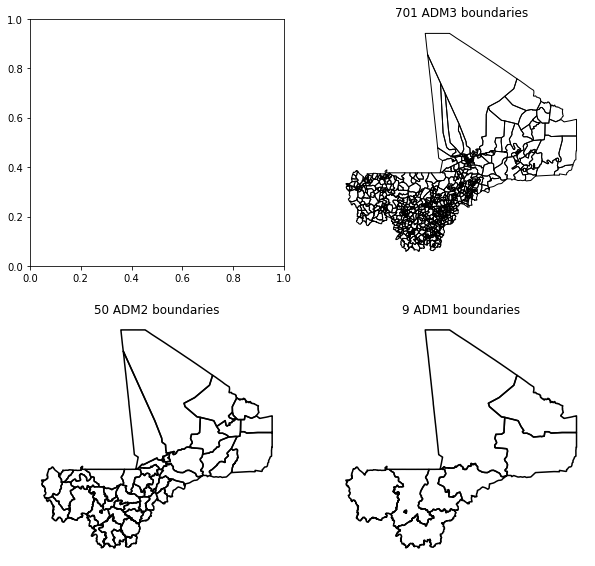

In [705]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
# geob4.boundary.plot(ax=ax[0, 0], color='black', linewidth=0.5).set_axis_off()
# ax[0, 0].set_title(f'{len(geob4)} ADM4 boundaries')
geob3.boundary.plot(ax=ax[0, 1], color='black', linewidth=1).set_axis_off()
ax[0, 1].set_title(f'{len(geob3)} ADM3 boundaries')
geob2.boundary.plot(ax=ax[1, 0], color='black').set_axis_off()
ax[1, 0].set_title(f'{len(geob2)} ADM2 boundaries')
geob1.boundary.plot(ax=ax[1, 1], color='black').set_axis_off()
ax[1, 1].set_title(f'{len(geob1)} ADM1 boundaries')
# plt.axis('off')

In [706]:
#master_table = pd.read_csv(os.path.join(input_dir, "tom_formatted", "hierarchy", "tom_edited_mali_collapsed.csv"), encoding='utf-8')
# in this case received an error when trying to import as latin-1
master_table = pd.read_csv(os.path.join(input_dir, "tom_formatted", "hierarchy", "tom_edited_mali_collapsed.csv"), encoding='latin-1')

In [707]:
master_table.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5
0,Mali,Bamako,CRLD,zzz a supprimer,ZCorbeille
1,Mali,Bamako,District Commune I,Asacko Nord,ASACKO NORD


In [708]:
len(master_table)

1891

In [709]:
print(f"Unique Level 2: {len(master_table.orgunitlevel2.unique())}")
print(f"Unique Level 3: {len(master_table.orgunitlevel3.unique())}")
print(f"Unique Level 4: {len(master_table.orgunitlevel4.unique())}")
print(f"Unique Level 5: {len(master_table.orgunitlevel5.unique())}")

Unique Level 2: 11
Unique Level 3: 76
Unique Level 4: 1473
Unique Level 5: 1855


In [710]:
print(f"Unique Geoboundaries Adm 1: {len(geob1)}")
print(f"Unique Geoboundaries Adm 2: {len(geob2)}")
print(f"Unique Geoboundaries Adm 3: {len(geob3)}")
#print(f"Unique Geoboundaries Adm 4: {len(geob4)}")

Unique Geoboundaries Adm 1: 9
Unique Geoboundaries Adm 2: 50
Unique Geoboundaries Adm 3: 701


In [711]:
geob2

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Bamako,,8926073B64014376877490,MLI,ADM2,"POLYGON ((-7.92938 12.68171, -7.92966 12.68184..."
1,Ansongo,,8926073B90341072377578,MLI,ADM2,"POLYGON ((1.32448 16.90639, 1.03227 16.61402, ..."
2,Bourem,,8926073B84614450489986,MLI,ADM2,"POLYGON ((1.17767 17.69959, 1.15458 17.70648, ..."
3,Gao,,8926073B21578619246094,MLI,ADM2,"POLYGON ((1.32448 16.90639, 1.65353 17.57350, ..."
4,Menaka,,8926073B55463907794266,MLI,ADM2,"POLYGON ((1.31144 15.27381, 1.34241 15.27543, ..."
5,Bafoulabe,,8926073B9201374937054,MLI,ADM2,"POLYGON ((-10.19528 14.60615, -10.27128 14.638..."
6,Diema,,8926073B17500772127777,MLI,ADM2,"POLYGON ((-9.82228 14.25412, -9.75029 14.29212..."
7,Kayes,,8926073B50456005927577,MLI,ADM2,"POLYGON ((-10.76957 14.62765, -10.77667 14.630..."
8,Kenieba,,8926073B29096122960907,MLI,ADM2,"POLYGON ((-11.46925 13.69106, -11.49825 13.636..."
9,Kita,,8926073B55037454613491,MLI,ADM2,"POLYGON ((-10.25643 12.83592, -10.24856 12.834..."


## Match health list admin names to shapefile admin names
### Match orgunitlevel4 to geoboundaries Adm 3
Try using fuzzy matching  

In [712]:
level4_list = list(master_table.orgunitlevel4.unique())
level4_list.sort()
geob3_list = list(geob3.shapeName)
geob3_list.sort()

Print names one at a time for both datasets one letter at a time, and manually inspect

In [713]:
for letter in ascii_uppercase:
    print(f'begins with letter {letter}')
    level4_sublist = [name for name in level4_list if name[0]==letter]
    geob3_sublist = [name for name in geob3_list if name[0]==letter]

    if len(level4_sublist)>0:
        print("Master list level 4")
        print("\t"+str(level4_sublist))
    if len(geob3_sublist) >0:
        print("Geoboundaries adm3")
        print("\t"+str(geob3_sublist))
        
    print("\n")

begins with letter A
Master list level 4
	['Abakoria', 'Aballag', 'Abeibara Central', 'Abosac', 'Achibogho', 'Adalwa 1', 'Adalwa 2', 'Adarmalane', 'Adasco', 'Adeken', 'Adiora', 'Adjel-Hoc', 'Afirnane', 'Agamhor', 'Agazaragane', 'Agdilinta', 'Aghabo', 'Aglal', 'Agouni', 'Ahl Cheick', 'Al Ou la', 'Al-Matlaa', 'Al-Ourche central', 'Aladi', 'Alasso', 'Aliou', 'Aljanabandja', 'Aljounoub', 'Allahina', 'Almoustarat Central', 'Alwalidji', 'Amasrakad', 'Amba', 'Ambidedi-Poste', 'Ambidedikore', 'Ambiri', 'Anderamboukane Central', 'Andiam', 'Anefif', 'Aniasco', 'Anonzegren', 'Ansongo Central', 'Aourou', 'Arabebe', 'Arawane central', 'Arham', 'Asacko Nord', 'Asaco-Sodia', 'Asacoba', 'Asacobafa', 'Asacobag', 'Asacobakon', 'Asacoboul1', 'Asacoboul2', 'Asacocy', 'Asacoda', 'Asacodes', 'Asacodjan', 'Asacodje', 'Asacodjeneka', 'Asacodjip', 'Asacodou', 'Asacodrab', 'Asacofa', 'Asacofadi', 'Asacoga', 'Asacoham', 'Asacohi', 'Asacoka', 'Asacokal', 'Asacokala ACI', 'Asacokalko', 'Asacokosa', 'Asacokoul-Poin

Manually adjust spellings of master health list to create more matches.

In [714]:
master_table.loc[:, "orgunitlevel4_edit"] = master_table.orgunitlevel4

In [715]:
# master_table.loc[master_table.orgunitlevel4 == "Bo City", "orgunitlevel4_edit"] = "Bo Town"
# master_table.loc[master_table.orgunitlevel4 == "Central 1 Zone", "orgunitlevel4_edit"] = "Central I"
# master_table.loc[master_table.orgunitlevel4 == "Central 2 Zone", "orgunitlevel4_edit"] = "Central II"
# master_table.loc[master_table.orgunitlevel4 == "East 1 Zone", "orgunitlevel4_edit"] = "East I"
# master_table.loc[master_table.orgunitlevel4 == "East 2 Zone", "orgunitlevel4_edit"] = "East II"
# master_table.loc[master_table.orgunitlevel4 == "East 3 Zone", "orgunitlevel4_edit"] = "East III"
# master_table.loc[master_table.orgunitlevel4 == "West 1 Zone", "orgunitlevel4_edit"] = "West I"
# master_table.loc[master_table.orgunitlevel4 == "West 2 Zone", "orgunitlevel4_edit"] = "West II"
# master_table.loc[master_table.orgunitlevel4 == "West 3 Zone", "orgunitlevel4_edit"] = "West III"
# master_table.loc[master_table.orgunitlevel4 == "Bagbwe", "orgunitlevel4_edit"] = "Bagbwe(Bagbe)"

Remove key words that confuse matching algorithm

In [716]:
remove_words(geob3, "shapeName", ['Town', 'City', 'Urban', 'Zone'])
remove_words(master_table, "orgunitlevel4_edit", ['Town', 'City', 'Urban', 'Zone'])

In [717]:
# level4_list = list(master_table.orgunitlevel4.unique())
level4_list = list(master_table.orgunitlevel4_edit.unique())
level4_list.sort()
geob3_list = list(geob3.shapeName)
geob3_list.sort()

In [718]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over orgunitlevel4_edit list
for name in level4_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob3_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level4" : name})
    dict_.update({"name_geob3" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm3 = pd.DataFrame(dict_list)
table_adm3_matches = table_adm3[table_adm3.score > 70].copy()

In [719]:
matches_pct = (len(table_adm3_matches) / len(level4_list))
'{:.2f}%'.format(matches_pct*100)

'59.13%'

In [720]:
# could save this list for someone to confirm matches manually
# for now take input noting which ones should be dropped based on quick inspection
table_adm3_matches.loc[table_adm3_matches.score<=80]

,name_level4,name_geob3,score
10,Adiora,Diora,73
18,Agouni,Tougouni,71
23,Aladi,Alafia,73
24,Alasso,Yasso,73
36,Anderamboukane Central,Anderamboukane,78
...,...,...,...
1463,Zignasso,Zangasso,75
1464,Zinda,Zanina,73
1468,ZÃ©bala,Zebala,77
1469,ZÃ©goua,Zegoua,77


In [721]:
for idx, row in table_adm3_matches.loc[table_adm3_matches.score<=80].iterrows():
    print(row)
    print('\n')
    #drop_input = input("Drop? If no, leave blank: ")
#     if len(drop_input)>0:
#         table_adm3_matches.drop(idx, axis=0, inplace=True)

name_level4    Adiora
name_geob3      Diora
score              73
Name: 10, dtype: object


name_level4      Agouni
name_geob3     Tougouni
score                71
Name: 18, dtype: object


name_level4     Aladi
name_geob3     Alafia
score              73
Name: 23, dtype: object


name_level4    Alasso
name_geob3      Yasso
score              73
Name: 24, dtype: object


name_level4    Anderamboukane Central
name_geob3             Anderamboukane
score                              78
Name: 36, dtype: object


name_level4    Baala
name_geob3       Bla
score             75
Name: 108, dtype: object


name_level4    Babala
name_geob3      Bamba
score              73
Name: 109, dtype: object


name_level4    Babougou
name_geob3     Bougoula
score                75
Name: 110, dtype: object


name_level4      Badogo
name_geob3     Madougou
score                71
Name: 113, dtype: object


name_level4     Bafarara
name_geob3     Bara Sara
score                 71
Name: 115, dtype: object


nam

In [722]:
matches_pct = (len(table_adm3_matches) / len(level4_list))
'{:.2f}%'.format(matches_pct*100)

'59.13%'

### Match orgunitlevel3 to geo Adm 2

In [723]:
master_table.loc[:, "orgunitlevel3_edit"] = master_table.orgunitlevel3

In [724]:
# remove_words(geob2, "admin2Name", [" City Council", " District Council", " Municipal Council"])
remove_words(master_table, "orgunitlevel3_edit", ["District "])
remove_words(geob2, "shapeName", ['City Council', 'District Council', 'Municipal Council'])
#remove_words(geob2, "ADMIN2", [" City Council", " District Council", " Municipal Council"])

In [725]:
level3_list = list(master_table.orgunitlevel3_edit.unique())
level3_list.sort()
geob2_list = list(geob2.shapeName)
geob2_list.sort()
# fews2_list = list(fews2.ADMIN2)
# fews2_list.sort()

Print names one at a time for both datasets one letter at a time, and manually inspect

In [726]:
for letter in ascii_uppercase:
    print(f'begins with letter {letter}')
    level3_sublist = [name for name in level3_list if name[0]==letter]
    geob2_sublist = [name for name in geob2_list if name[0]==letter]
    #fews2_sublist = [name for name in fews2_list if name[0]==letter]
    if len(level3_sublist)>0:
        print("Master list level 3")
        print("\t"+str(level3_sublist))
    if len(geob2_sublist) >0:
        print("Geoboundaries adm2")
        print("\t"+str(geob2_sublist))
#     if len(fews2_sublist) > 0:
#         print("FEWS adm2")
#         print("\t"+str(fews2_sublist))
#     print("\n")

begins with letter A
Master list level 3
	['Abeibara', 'Achouratt', 'Al-Ourche', 'Almoustarat', 'Anderamboukane', 'Ansongo', 'Arawane']
Geoboundaries adm2
	['Abeibara', 'Ansongo']
begins with letter B
Master list level 3
	['Bafoulabe', 'Banamba', 'Bandiagara', 'Bankass', 'Baroueli', 'Bla', 'Bougouni', 'Boujbeha', 'Bourem']
Geoboundaries adm2
	['Bafoulabe', 'Bamako', 'Banamba', 'Bandiagara', 'Bankass', 'Baroueli', 'Bla', 'Bougouni', 'Bourem']
begins with letter C
Master list level 3
	['CRLD', 'Commune I', 'Commune II', 'Commune III', 'Commune IV', 'Commune V', 'Commune VI']
begins with letter D
Master list level 3
	['Diema', 'Dioila', 'DirÃ©', 'DjennÃ©', 'Douentza']
Geoboundaries adm2
	['Diema', 'Dioila', 'Dire', 'Djenne', 'Douentza']
begins with letter E
begins with letter F
Master list level 3
	['Fana', 'Foum-Alba']
begins with letter G
Master list level 3
	['Gao', 'Goundam', 'Gourma-Rharous']
Geoboundaries adm2
	['Gao', 'Goundam', 'Gourma-Rharous']
begins with letter H
begins with le

In [727]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in level3_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob2_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level3" : name})
    dict_.update({"name_geob2" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm2 = pd.DataFrame(dict_list)
table_adm2_matches = table_adm2[table_adm2.score > 75]

In [728]:
matches_pct = (len(table_adm2_matches) / len(level3_list))
'{:.2f}%'.format(matches_pct*100)

'63.16%'

Loop through each row in master table, and add new attribute names (adm3 and adm2), if the names produced matches in the lookup tables

In [729]:
master_table_copy = master_table.copy()

In [730]:
for idx, row in master_table_copy.iterrows():
    
    if row.orgunitlevel4_edit in list(table_adm3_matches.name_level4):
        
        match = table_adm3_matches.loc[table_adm3_matches.name_level4==row.orgunitlevel4_edit, "name_geob3"].iloc[0]
        master_table_copy.loc[idx, 'adm3'] = match
        
    if row.orgunitlevel3_edit in list(table_adm2_matches.name_level3):
        
        match = table_adm2_matches.loc[table_adm2_matches.name_level3==row.orgunitlevel3_edit, "name_geob2"].iloc[0]
        master_table_copy.loc[idx, 'adm2'] = match

In [731]:
master_table_copy.adm2.isna().sum()

515

In [732]:
master_table_copy.adm3.isna().sum()

873

In [733]:
master_table_copy.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel4_edit,orgunitlevel3_edit,adm3,adm2
0,Mali,Bamako,CRLD,zzz a supprimer,ZCorbeille,zzz a supprimer,CRLD,NaN,NaN
1,Mali,Bamako,District Commune I,Asacko Nord,ASACKO NORD,Asacko Nord,Commune I,NaN,NaN


# Match to locations from alternative sources based on facility name


## Health Sites IO
Import Health Sites from HealthSites.io  
Health sites come in both a node and a way shapefile. You need to import both to get all the sites.  
In QGIS, I created centroids from the ways then merged it with the points.

In [734]:
nodes_io = gpd.read_file(os.path.join(input_dir, "healthsitesio", "MLI", "merged_MLI_healthsites.shp"))

In [735]:
nodes_io = nodes_io.loc[~nodes_io.name.isna()].copy()

In [736]:
nodes_io['name'] = nodes_io['name'].str.lower()

In [737]:
words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']

In [738]:
records = master_table_copy.copy()
records['NAME'] = records['orgunitlevel5'].str.lower()

In [739]:
remove_words(nodes_io, 'name', words_to_remove)
remove_words(records, 'NAME', words_to_remove)

In [740]:
records['geocoding_method'] = "None"

In [741]:
records

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel4_edit,orgunitlevel3_edit,adm3,adm2,NAME,geocoding_method
0,Mali,Bamako,CRLD,zzz a supprimer,ZCorbeille,zzz a supprimer,CRLD,NaN,NaN,zcorbeille,None
1,Mali,Bamako,District Commune I,Asacko Nord,ASACKO NORD,Asacko Nord,Commune I,NaN,NaN,asacko nord,None
2,Mali,Bamako,District Commune I,Asacko Nord,Clinique Daccouchement PrivÃ©e Danaya,Asacko Nord,Commune I,NaN,NaN,clinique daccouchement privã©e danaya,None
3,Mali,Bamako,District Commune I,Asacoba,ASACOBA,Asacoba,Commune I,NaN,NaN,asacoba,None
4,Mali,Bamako,District Commune I,Asacoba,Cabinet Medical FONDATION SADIA,Asacoba,Commune I,NaN,NaN,cabinet medical fondation sadia,None
...,...,...,...,...,...,...,...,...,...,...,...
1886,Mali,Tombouctou,District Tombouctou,TeherdjÃ©,Teherdje,TeherdjÃ©,Tombouctou,NaN,Tombouctou,teherdje,None
1887,Mali,Tombouctou,District Tombouctou,Tin Telout,Tin Telout,Tin Telout,Tombouctou,NaN,Tombouctou,tin telout,None
1888,Mali,Tombouctou,District Tombouctou,Tindjambane,Tindjambane,Tindjambane,Tombouctou,NaN,Tombouctou,tindjambane,None
1889,Mali,Tombouctou,District Tombouctou,Toya,Toya,Toya,Tombouctou,Toya,Tombouctou,toya,None


### note: since only partial matches with admin 3 and admin 2, matching will occur if point is within the district or not. However, since there is no point in district validation, increase the matching benchmark.

In [742]:
for idx, row in tqdm(records.iterrows()):
    
    # Check if there is another entry with location
    match, score = match_name(row.NAME, list(nodes_io['name']), 80)
    
    if score > 0:
        print(row.NAME, match)
        matching_row = nodes_io.loc[nodes_io['name']==match].copy()
        res = matching_row.iloc[0]
        
        geocoded=False
        if not pd.isna(row.adm3):
            adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
            if adm3.contains(res.geometry).values[0] == True:
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 3"
                geocoded=True
        
        if (geocoded==False) and (not pd.isna(row.adm2)):
            adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
            if adm2.contains(res.geometry).values[0] == True:            
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 2"
                geocoded=True
                
        if geocoded==False:
            records.loc[idx, "longitude"] = res.geometry.x
            records.loc[idx, "latitude"] = res.geometry.y
            records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and without admin verification"


12it [00:00, 56.87it/s]

asacoba asacobafa
cabinet medical fondation sadia cabinet medical yonki saha
cabinet medical teriya cabinet medical anta
asacoboul1 asacoboul
asacoboul2 asacoboul
asacodjan asacodje
de sante cherifoula de sante cherifla


23it [00:00, 52.97it/s]

asacodje asacodje
asacodou asacoboul
asacofadi asacofa
asacokosa asacoka
asacomsi asacomi
cabinet kaya cabinet bakadia
asacobag asacobafa
asacohi asacomi


38it [00:00, 56.87it/s]

cabinet medical le salut cabinet medical le soutien
clinique medical life clinique medical lumiã¨re
clinique medicale kaidara clinique medicale eureka
clinique pitie clinique pitiã©
clinique salia daou clinique salia daou
clinique wassa clinique aya
asacome asacomi
asacomi asacomi


61it [00:00, 67.19it/s]

clinique ata clinique atlas
benkady benky
asacobakon asacoko
clinique farako clinique farako
asacodes asacodje
clinique cdi keneya clinique keneya


81it [00:01, 76.17it/s]

cabinet de consultation amppf cabinet de consultatation rapha
asacoob asacoko
cabinet medical rosette cabinet mã©dical rosette
cabinet de consultation cdt cabinet de consultations
ascom asacomi
mutec sante mutec santã©
clinique diawara clinique hawa
cabinet espoir ii cabinet de soin titi


98it [00:01, 70.80it/s]

cabinet sagefemme niana cabinet sage-femme nacoura
clinique mã©dicale astra clinique mã©dicale salam
asacodjip asacodjip
clinique medico chirugicale source de vie clinique mã©dicale source de vie
clinique femina clinique lafia
polyclinique kabala clinique kabala
polyclinique pasteur clinique pasteur


128it [00:01, 74.94it/s]

asacoka asacoka
cabinet  mã©dical keneyaso cabinet mã©dical keneya blow
clinique lahidou clinique ambodou
cabinet djigiya sante cabinet djiguiya
clinique mãdical sept clinique medicale sept
cabinet medical guerison cabinet mã©dical bonne guerison
cabinet medical moussa keita cabinet medical mossoula
cabinet de soins niana cabinet de soins teriya
clinique nana clinique banan


156it [00:02, 84.58it/s]

hopital mali gavardo hã´pital mali gavardo
cabinet mouna cabinet nouna
cabinet mã©dical darchifa cabinet mã©dical amza
asacoda asacoka
asacoga asacoka
cabinet medical sianwa cabinet medical anta
cabinet bama cabinet bakadia


174it [00:02, 71.97it/s]

cabinet bayaba cabinet bakadia
asacokal asacoka
cabinet medical doniya cabinet medical anta
cabinet medical wassa cabinet mã©dical wassa
cabinet mã©dical - siloe cabinet mã©dical jasmine
clinique safi clinique lafia
asacokalko asacoka


195it [00:02, 81.61it/s]

cabinet mã©dical cocotier cabinet mã©dical doucoure
clinique pape clinique pasteur
polyclinique mohamed 5 polyclinique mohamed v
clinique sadim clinique mariam
cabinet medical ophtalmologie lafia cabinet mã©dical d'opthalmologie
clinique medicale youma clinique medicale eureka
cabinet sage femme ouidah cabinet sage-femme nacoura


214it [00:02, 73.42it/s]

asacobafa asacobafa
clinique medical banan clinique medical brico
cabinet dily cabinet medical
medical teriya medical teriya
clinique nour clinique nour
asacocy asacocy
medical bayo assa cabinet medical bayo assa
asacofa asacofa
cabinet medical  bara cabinet medical anta
cabinet medical djidia cabinet medical anta
cabinet medical keneya cabinet medical anta


241it [00:03, 70.65it/s]

cabinet medical  nadja cabinet medical anta
asacoma asacoka
clinique reference clinique experience
asacomiss asacomi
clinique espoir clinique espoir
asaconia asaconia
cabinet koura cabinet nouna
cabinet medical keneyassoâ cabinet medical keneyasso de garalo


287it [00:03, 93.68it/s]

infirmerie garnison base aerienne 101 senou infirmerie garnison base aã©rienne 101 senou
asacoso asacoko
clinique  medical atlas clinique mã©dicale salam
clinique mã©dical mahadi clinique mã©dicale defi
dangha dangha


411it [00:04, 117.78it/s]

cabinet medical mohamed v cabinet medical mozart
cabinet mã©dical yonkissaha cabinet medical yonki saha
cabinet mã©dical djiguiya cabinet mã©dical daou
cabinet de soins koumpoula cabinet de soins soungoba


439it [00:04, 87.89it/s] 

cabinet de soins diamtan cabinet de soin titi
cabinet mã©dical - amina cabinet mã©dical amza
cabinet mã©dical oumar - sy cabinet mã©dical koumarã© yaya
de santã© de sobocou de santã© de foulabougou
cabinet mã©dical espoir cabinet mã©dical santoro


464it [00:05, 82.15it/s]

cabinet mã©dical lafiabougou - sud cabinet medical lafia-sud
cabinet mã©dical mali sadio cabinet mã©dical wassa
cabinet mã©dical tã©riya cabinet mã©dical mandã©
cabinet mã©dical du fleuve cabinet mã©dical doucoure


512it [00:05, 97.18it/s]

cabinet mã©dical bien etre cabinet mã©dical kita gare
cabinet mã©dical keneyasso cabinet mã©dical keneya blow
cabinet lafia cabinet maliba
cabinet mã©dical keneyasso koffi cabinet mã©dical keneya blow


525it [00:05, 67.17it/s]

cabinet mã©dical danaya cabinet mã©dical badenya
cabinet mã©dical destin cabinet mã©dical jasmine
cabinet mã©dical keneyaboulo cabinet mã©dical keneya blow


582it [00:06, 98.56it/s]

cabinet mã©dical demba gadiaba cabinet mã©dicale adam
cabinet mã©dical silangroi cabinet mã©dical santoro


649it [00:06, 117.48it/s]

cabinet mã©dical diafounou cabinet mã©dical daou
cabinet mã©dical zantonon cabinet mã©dical santoro
cabinet mã©dical kaniaga cabinet mã©dical kita gare


665it [00:07, 87.57it/s] 

cabinet medical yonki saha cabinet medical yonki saha
cabinet mã©dical kremissoise cabinet mã©dical rosette
cabinet mã©dical balanzan cabinet mã©dical amza


678it [00:07, 69.59it/s]

cabinet mã©dical sambakanou cabinet mã‰dical samba
cabinet mã©dical yonki saha cabinet medical yonki saha
cabinet mã©dical wassoulou cabinet mã©dical wassa


741it [00:07, 100.44it/s]

cabinet medical nando cabinet medical anta
cabinet mã©dical baniko cabinet mã©dical fakola
cabinet de consultation liberte cabinet de consultations


770it [00:08, 88.89it/s] 

cabinet mã©dical kolombada cabinet mã©dical fakola
koni kondi
clinique mã©dicale dinandougou clinique mã©dicale wagadou


829it [00:08, 131.23it/s]

danga dangha


871it [00:08, 126.47it/s]

cabinet mã©dical beledougou cabinet mã©dical doucoure
nossombougou kossambougou
chola chouala


902it [00:08, 103.86it/s]

cabinet mã©dical oumar diallo cabinet mã©dical koumarã© yaya
tougouni bougouni


964it [00:09, 146.96it/s]

cabinet mã©dical espoir cabinet mã©dical santoro


987it [00:09, 149.39it/s]

mka central pmi central
cabinet medical le hogon cabinet medical le soutien


1026it [00:09, 132.82it/s]

cabinet medical yate cabinet medical anta
sangha dangha


1055it [00:09, 129.92it/s]

cabinet mã©dical seno cabinet mã©dical santoro
niaouro nioro


1126it [00:10, 176.03it/s]

cabinet mã©dical toguna cabinet mã©dical fona
cabinet mã©dical duflo cabinet mã©dical fona
cabinet mã©dical mawa cabinet mã©dical amza


1162it [00:10, 125.02it/s]

cabinet nando cabinet mande
cabinet groupe mã©dical cabinet mã©dical
cabinet medical les etoiles cabinet medical le secours


1221it [00:11, 142.17it/s]

cabinet mã©dical fraternitã© cabinet mã©dical mandã©
cabinet mã©dical de manankoro cabinet mã©dical santoro


1263it [00:11, 145.70it/s]

cabinet medical folona cabinet mã©dical fona
kai kati
cabinet  medical toguna cabinet medical anta


1298it [00:11, 117.51it/s]

cabinet de soins pitiagoma cabinet de soin titi
cabinet  medical keneya cabinet medical anta
cabinet mã©dical nord sud cabinet mã©dical daou


1313it [00:12, 86.52it/s] 

cabinet medical solidarite cabinet medical mozart
cabinet medical alliance cabinet medical anta
cabinet de soins ngolodiana cabinet de soins soungoba


1352it [00:12, 106.10it/s]

maison mã©dicale maison medicale
koloni kolokani
clinique lafia clinique lafia


1428it [00:12, 145.69it/s]

cabinet medical la reference cabinet mã©dical la rã©fã©rance
kouloukan kolokani


1465it [00:13, 149.25it/s]

cabinet de soins ifm cabinet de soins chã©rif
cabinet de soins keneya so cabinet de soins teriya
cabinet de soins djiguiya cabinet de soins teriya


1526it [00:13, 149.67it/s]

cabinet berthela cabinet bere
bogoni bougouni


1586it [00:13, 125.98it/s]

cabinet mã©dical ba mariama cabinet mã©dical amza
cabinet de soins lafia cabinet de soins teriya
cabinet de soins keneya cabinet de soins teriya


1629it [00:14, 126.45it/s]

cabinet de soins nantenin cabinet de soins teriya
cabinet medical a. ongoiba cabinet medical anta
clinique keneya clinique keneya


1645it [00:14, 112.44it/s]

cabinet mã©dical yadama keneyaso cabinet mã©dical badenya
clinique mã©dicale lafia clinique mã©dicale defi


1678it [00:14, 99.65it/s] 

clinique mã©dicale alassane clinique mã©dicale salam
clinique mã©dicale balimaya clinique mã©dicale salam
clinique mã©dicale santoro clinique mã©dicale salam
cabinet de soins yaya cabinet de soins teriya


1719it [00:15, 116.03it/s]

maternitã© rurale de manzara maternite rurale de nansala
sidosoninkoura cscom sidosoninkoura


1784it [00:15, 137.59it/s]

cabinet mãdical espoir cabinet mã©dical santoro
arham arham
bourem sidi amar bourem sidi amar


1800it [00:15, 103.64it/s]

dangha dangha
garbacoira garbacoira
kondi kondi


1891it [00:16, 117.91it/s]


In [743]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 2,5,0.3%
Location from Health Sites IO and within admin 3,10,0.5%
Location from Health Sites IO and without admin verification,180,9.5%
None,1696,89.7%


## RHINoVision Master Facility List Decision Support System

In [744]:
#rhino = pd.read_excel(os.path.join(input_dir, "rhino", "00 SSA MFL (130219).xlsx"), 0)
rhino = pd.read_csv(os.path.join(input_dir, "rhino", "00 SSA MFL (130219).csv"))

In [745]:
rhino = rhino.loc[rhino.Country=="Mali"].copy()

In [746]:
rhino['name'] = rhino['Facility name'].str.lower()

In [747]:
remove_words(rhino, 'name')

In [748]:
rhino.loc[:, "geometry"] = rhino.apply(lambda x: Point(x.Long, x.Lat), axis=1)
rhino = gpd.GeoDataFrame(rhino, geometry='geometry', crs='EPSG:4326')

### note: since only partial matches with admin 3 and admin 2, matching will occur if point is witin the district or not. However, since there is no point in district validation, increase the matching benchmark.

In [749]:
for idx, row in tqdm(records.iterrows()):
    
    if row.geocoding_method=="None":
        
        # Check if there is another entry with location
        match, score = match_name(row.NAME, list(rhino['name']), 80)
        
        if score > 0:
            print(row.NAME, match)
            matching_row = rhino.loc[rhino['name']==match].copy()
            res = matching_row.iloc[0]

            geocoded=False
            if not pd.isna(row.adm3):
                adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
                if adm3.contains(res.geometry).values[0] == True:
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 3"
                    geocoded=True

            if (geocoded==False) and (not pd.isna(row.adm2)):
                adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
                if adm2.contains(res.geometry).values[0] == True:            
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Health Sites and within admin 2"
                    geocoded=True

            if geocoded==False:
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites without admin verification"

22it [00:00, 190.19it/s]

asacko nord asaconord
asacos asacose
asacosisou asacosisou
abosac abosac
boniaba boniaba


84it [00:00, 177.14it/s]

asacodrab asacodrab
asacokoul-point asacokoul point
asacotom asacotom
ascodar asacodar
asacodjeneka asacodjeneka
asacoham asacoham


136it [00:00, 157.42it/s]

asacola1 asacola i
asacola2 asacola i
asacolab5 asacola b5
asacolabasad asacolabasad
asacosek asacosek
asacosekasi asacosekasi
adasco adasco


195it [00:01, 142.32it/s]

asacokala aci asacokal aci
asacosab1 asacosab i
asacosab2 asacosab i
asacosab3 asacosab i
asacotoqua asacotoqua
ascoda asacoda
ascom-bacodji ascombacodji


249it [00:01, 184.87it/s]

aniasco aniasco
asaco-sodia asacosodia
asacose asacose
asacoyici asacoyir
asacoyir asacoyir


271it [00:01, 136.35it/s]

ersane ersane
tabankort tabankort
tarkint tarkint
ansongo central niono central
bara bara
bazigourma bazi gourma
bazihaoussa bazi haoussa
bentia bentia
fafa fafa
hourara hourara
indelimane indelimane
labbã©zanga labbezanga
lellehoye lellehoye
ouatagouna ouattagouna


289it [00:02, 62.73it/s] 

talataye talataye
tassiga tassiga
tessit tessit
tinhamma tin-hamma
abakoria abakoira
bahondo bahondo
baria baria
bourem central bourem central


302it [00:02, 40.43it/s]

chabaria chabaria
ha ha
imilach imilache
karabassane karabassane


312it [00:03, 40.34it/s]

kermachoe kermachoe
moudakane moudakane
taboye taboye
tinsako tinsakou


321it [00:03, 39.28it/s]

aljanabandja aljanabandja
bagnandji bagnadji
berrah berrah
boulgoundje boulgoundie
boya boya


328it [00:03, 33.56it/s]

diebock djebock
dorey doreye
doro dioro
forgo forgho


334it [00:03, 30.89it/s]

gadeye gadeye
gargouna gargouna
hamakouladji hamakouladji
haoussa foulane haoussa foulane


345it [00:04, 35.19it/s]

iminaguel imnaguel
lobou lobou
ntahaka ntahaka
sossokoira sossokoira


357it [00:04, 36.02it/s]

tacharane tacharane
tamakoutat tamkoutat
tin aouker tin aouker
wabaria wabaria
zinda zinda


362it [00:04, 33.02it/s]

bamafele bamafele
diakaba diakaba
diakitela diakitela
dialakon diakon


366it [00:04, 25.31it/s]

diokeli diokeli
gounfan gounfan
koundian koundian


377it [00:05, 30.12it/s]

mahina mahina
marena marena
neguetabali neguetabali
oualia oualia


384it [00:05, 25.24it/s]

ouassala ouassala
selinkegny selinkegni
sitakoto sitaninkoto
bema bema


387it [00:05, 22.69it/s]

dianguirde dianguirde
dianguounte camara diangounte camara
dioumara dioumara
diema central diema central


395it [00:05, 26.92it/s]

dieoura dieoura
debomassassi debomassassi
farabougou farabougou
fassoudebe fassoudebe
fatao fatao


402it [00:06, 24.93it/s]

gomitradougou guomitradougou
groumera groumera
guedebine guedebine
koungo koungo
lakamane lakamane


412it [00:06, 27.83it/s]

lambidou lambidou
lattakaf latakaff
madiga sacko madiga sacko
sansankide sansankide
tinkare tinkare


416it [00:06, 25.10it/s]

torodo torodo
ambidedi-poste ambidedi poste
ambidedikore ambidedi-kore
aourou aourou
babala babala


423it [00:07, 22.70it/s]

bafarara bafarara
batama batama
boutinguisse bountinguisse
dagassenou dagassenou


430it [00:07, 25.16it/s]

dialakasso diala khasso
dialane diallane
diamou diamou
diboli diboli


433it [00:07, 21.02it/s]

djinguilou djinguilou
dramane dramane
fegui fegui
gabou gabou


439it [00:07, 18.00it/s]

gory-gopela gori - gopela
goumera goumera
gounka goundaka
kakadian kakadian


449it [00:08, 23.75it/s]

kayes ndi kayes ndi
koniakary koniakary
kouloun koulou
koussane koussane


459it [00:08, 29.25it/s]

cmie kayes lafiabougou kayes lafiabougou
lany-tounka lany tounka
logo-saboussire logosaboucire
lontou lontou


463it [00:08, 24.82it/s]

leya leya
marena-diombougou marena diombougou
marena-gadiaga marena gadiaga
niamiga niamiga


473it [00:08, 31.36it/s]

plateau plateau
sadiola sadiola
segala segala
selifely selifely
serenaty serenaty


477it [00:09, 24.79it/s]

sero sero
somankidi somankidi
tafassirga tafacirga
troun troun


484it [00:09, 23.38it/s]

balandougou balandougou
baye-kenieba baye kenieba
dabia dabia
diabarou diabarou


490it [00:09, 24.97it/s]

dittin dittin
dombia dombia
fadougou madougou
falea falea


501it [00:10, 29.80it/s]

faraba faraba
guene-gore guenegore
guenoubatan guenoubantan
kassama kassama
kouroukoto kouroukoto
kenieba central kenieba central


514it [00:10, 38.09it/s]

keniegoulou keniegoulou
sagalo sagalo
sanfagadala sanfagadala
sitakily sitakily


525it [00:10, 42.66it/s]

tabakoto tabakoto
tambafigna tambaga
badinko badinko
balandougou balandougou


530it [00:10, 38.90it/s]

bendougouba bendougouba
boudofo boudofo
bougaribaya bougaribaya


535it [00:10, 30.58it/s]

dafela dafela
darsalam kita darsalam-kita
djidian djidian
fladougou marena fladougou marena
founia moribougou founia-moribougou


542it [00:11, 23.66it/s]

goro goro
guenikoro guenikoro
kassaro kassaro
kofeba kofeba


545it [00:11, 19.65it/s]

kokofata kokofata
kotouba kotouba
kourounikoto kourouninkoto


548it [00:11, 17.57it/s]

madina mahina
makandiambougou makandiambougou
namala nampala


561it [00:12, 24.77it/s]

sandiambougou sandiambougou
sebekoro sebekoro
senko senko
sirakoro sirakoro
sitanikoto sitaninkoto
tambaga tambaga


564it [00:12, 24.42it/s]

toukoto toukoto
awoiny awoiny
banierekore baniere kore
diabaguela diabaguela


570it [00:12, 22.48it/s]

diabidiala diabidiala
diabigue diabigue
dianwely kounda dianwely counda
diarah diarrah
diaye coura diaye koura


576it [00:12, 19.28it/s]

fosse karta fosse kaarta
frandalla frandalah
gadiaba kadiel gadiaba-kadiel
gavinane gavinane


579it [00:13, 17.90it/s]

gogui gogui
guetema guetema
hamake hamake
korera kore korera kore


587it [00:13, 21.35it/s]

kouroukere kouroukere
monzombougou monzombougou
sambagorã© sambagore
sandare sandare
simbi simbi


593it [00:13, 21.24it/s]

tichitt tichitt
tintiba tintiba
tourourou tourourou
troungoumbe troungoumbe
yerere yerere


599it [00:13, 21.01it/s]

youri youri
bendougou bendougou
diakon diakon
diallan diallan
djoufoya tintokan djoufoya tintoka
douale douale


606it [00:14, 25.72it/s]

demeke demeke
goundara goundara
kembe kembe
kolondinkoye kolondinkoye
madalaya madalaya
madihawaya madihawaya


612it [00:14, 27.14it/s]

modinkanou modincanou
oussibidiagna oussoubidiagna
sawane sawane
sibindi sibindy
sitakourou sitakourou
tigana tigana
toumbinassou toumbinassou


621it [00:14, 32.70it/s]

trentimou trentimou
balea balea
galle galle
kabalea kabelea
sagabari sagabari
diougounte dioungounte


631it [00:14, 32.65it/s]

djougoun djougoun
guemoukouraba guemoukouraba
kagoro mountan kagoro-mountan
kenienife kenienife
niagane niagane
sefeto sefeto


639it [00:15, 32.82it/s]

badiougoula bandiougoula
biladjimi biladjimi
dialaka dialaka
dioncoulane dioncoulane
diongaga diongaga


647it [00:15, 25.39it/s]

dogofri dogofri
fanga fanga
gory gory
hamdallaye yelimane hamdallaye yelimane
kanguessanou kanguessanou


657it [00:15, 26.94it/s]

kersignane kaniaga kersignane kaniaga
kirane kirane
kodje kodje
kremis kremis
lakanguemou lakanguemou


662it [00:15, 30.91it/s]

lambatra lambatra
marena tringa marena tringa
niogomera nogomera
ouologuela ouologuela


669it [00:16, 23.65it/s]

sambaga sambaga
takaba takaba
tambacara tambacara
waikanou waikanou
yaguine yaguine


681it [00:16, 27.14it/s]

yelimane central yelimane central
abeibara central abeibara central
aghabo aghabo
aliou aliou
anefif anefif


687it [00:17, 24.33it/s]

essouk essouk
etambar etambar
intadeinit intadeyni
kidal central kidal central
taghrist taghrist


699it [00:17, 32.48it/s]

telabit telabit
imboulal boulal
banamba  central banamba central
boron boron


703it [00:17, 33.48it/s]

bougouba bougoula
guessene guessene
kerouane kerouane
kiban kiban


707it [00:17, 27.82it/s]

kolobo kolobo
madina  sacko madina sacko
ntiele ntiele
ouaro ouaro


714it [00:18, 20.24it/s]

ouleni ouleny
samakele samakele
sebete sebete
tota tota


720it [00:18, 20.18it/s]

touba touba
toubacoro toubacoro
toukoroba toukoroba
bamanantoun bamanantoum
banco banco
bole bole


730it [00:18, 25.86it/s]

degnekoro degnekoro
dioila central dioila central
falakono falakono
fissaba fissaba
kola kola


736it [00:18, 24.06it/s]

kounabougou gounambougou
maban maban
massigui massigui
n'gara ngara


739it [00:19, 20.69it/s]

n'golobougou ngolobougou
n'tobougou ntobougou
niantjila niantjila
sanankoro sanankoro


742it [00:19, 18.85it/s]

senou senou
seribila seribila
togo togo


749it [00:19, 20.34it/s]

toukoro toukoroba
wacoro wacoro
bougoukourala bougoucourala
dandougou dandougou
diebe diebe


756it [00:19, 23.52it/s]

djoumazana djoumazana
falako falako
fana fanga
fougadougou dougabougou
kerela kerela


765it [00:20, 27.37it/s]

konkon konkon
korokoro torokoro
kotoula kotoula
markacoungo marcacoungo
mena mena
nangola nangola


775it [00:20, 26.92it/s]

seyla seyla
tingole tingole
toukoro toukoroba
baguineda baguineda
dialakorobougou dialakorobougou
falani falani


782it [00:20, 29.78it/s]

kabala babala
kalabancoro kalabancoro
kalabancoro nerecoro kalabancoro nerekoro
kalabancro heremakono kalabancoro heremakono
mountougoula mountougoula
n'gouraba ngouraba


794it [00:21, 33.25it/s]

niamana niamana
sanancoroba sanankoroba
tanima tanima
balan-bakama balan-bakama
banancoro banankoro


802it [00:21, 28.99it/s]

faraba faraba
figuira tomo figuiratomo
kangaba central kangaba central
karan karan
kouremale kouremale


806it [00:21, 25.48it/s]

kenegoue keniegoue
manicoura manincoura
narena narena
salamale salamale


812it [00:21, 24.40it/s]

selefougou selefougou
tombola tombola
bancoumana bancoumana
bassabougou sabougou


815it [00:22, 21.82it/s]

daban daban
diago diago
dialacorodji dialakorodji
dio gare dio gare


821it [00:22, 21.96it/s]

djoliba djoliba
dogodouma dogodouma
dombila dombila
doubabougou doubabougou


824it [00:22, 19.39it/s]

faladie faladie
farabana farabana
farada farada


829it [00:22, 16.93it/s]

kabalabougou kabalabougou
kalifabougou kalifabougou
kanadjiguila kanadjiguila
koursalã© koursale


833it [00:22, 19.50it/s]

malibougou malibougou
moribabougou moribabougou
nana kenieba nana kenieba


841it [00:23, 20.54it/s]

neguela neguela
nioumamakana niouma makana
safo safo
sananfara sananfara


844it [00:23, 18.58it/s]

sandama sandama
sangarebougou sangarebougou
siby siby
soninkegny sonikegny


850it [00:23, 19.11it/s]

torodo torodo
yelekebougou yelekebougou
didieni didieni
doubabougou doubabougou
doubala soubala


853it [00:24, 19.28it/s]

guihoyo guihoyo
kolokani central kolokani central
koumi koumi
manta manta


859it [00:24, 19.77it/s]

massantola massantola
mercoya mercoya
niogona niokona
nonkon nonkon
ouolodo ouolodo


865it [00:24, 19.55it/s]

sabougou sabougou
sagabala sagabala
samantara samantara
sebekoro i sebekoro
segue segue


870it [00:24, 18.07it/s]

seriwala seriwala
sirakoroba sirakoroba
sonkenie sonkenie
tioribougou tioribougou


875it [00:25, 18.44it/s]

toussana toussana
dialakoro dialakoroba
doumba doumba
kamani kamani


883it [00:25, 22.34it/s]

kenenkoun kenenkou
kolebougou kolebougou
koulikoroba koulikoro-ba
massala massala


886it [00:25, 20.63it/s]

monzombala monzombala
n'gouni gouni
nyamina nyamina
sinzani sinzani


892it [00:25, 19.70it/s]

sirakorobougou sirakorobougou
sirakorola sirakorola
souban souban
seguela seguela


895it [00:26, 21.74it/s]

tienfala tienfala
tombougou tombougou
allahina allahina


907it [00:26, 26.51it/s]

balle balle
bediatt bediatt
bineou-niakate bineou niakate
boudjiguire boudjigire
boulal boulal


910it [00:26, 24.23it/s]

dalibougou malibougou
digan digan
dilly dilly


916it [00:26, 19.91it/s]

djigue djigue
fallou fallou
goumbou goumbou
guire guire


919it [00:27, 20.93it/s]

kaloumba kaloumba
karfabougou karfabougou
koira kora


925it [00:27, 18.60it/s]

koronga koronga
madina kagoro madina kagoro
mourdiah mourdiah
naoulena naoulena


933it [00:27, 22.30it/s]

nara central nara central
sampaga sampaga
sekolo sekoro
sountiana kouniana


941it [00:27, 25.44it/s]

waourou waourou
baala baala
beneko beneko
dangassa dangassa
dialakoroba dialakoroba


944it [00:28, 23.33it/s]

digan digan
faraba faraba
kafara kaara
kourouba kourouba
mana manta


955it [00:28, 28.58it/s]

marako farako
niagadina niagadina
safe-bougoula safe bougoula
sanankorodjitoumou sanankoro-djitoumou
tinkele tinkele
tiele tiele


963it [00:28, 30.49it/s]

aladi faladie
anderamboukane anderamboukane
inchinanane inchinanane
tagalalt tagalalt
tamalett tamalet
tinagaroft tinagaroff
inekar inekar


977it [00:28, 40.38it/s]

anonzegren anouzegrene
essakane essakane
intadeynã© intadeyni
madina mahina


1012it [00:29, 62.46it/s]

tabankort-mã©naka tabankort menaka
tidemene tidermene
bandiagara central bandiagara central
borko borko
bourgouma bougoula
diankassagou diangassagou
dogani bere dogani - bere
dourou dourou


1020it [00:29, 44.16it/s]

goundaka goundaka
iby siby
ireli ireli
kamba kamba
kargue kargue


1027it [00:29, 34.85it/s]

kendie kendie
kori maoude kori-maounde
mory mory
nando nando
ningari ningari


1038it [00:30, 31.02it/s]

ondougou ondougou
ouo ouo
songho songho
yendouma yendouma
bankass central bankass central


1043it [00:30, 30.28it/s]

baye baye
diallassagou diangassagou
diallaye diallaye
dimbal dimbal


1051it [00:31, 21.73it/s]

dounde dounde
ende ende
ganidah ganidah
gomossagou gomossagou
kani bonzon kani - bonzon
koulogo koulogon


1054it [00:31, 19.43it/s]

koulou koulou
niamnia niamia
ouenkoro ouenkoro


1063it [00:31, 22.68it/s]

pissa pissa
sama sama
soubala soubala
segue segue
yira yira


1066it [00:31, 20.85it/s]

bounguel bonguel
djenne central djenne central
gagna gagna
gomitogo gomitogo


1069it [00:31, 18.92it/s]

kandara kaara
koa koa
konio konio


1076it [00:32, 16.58it/s]

kouakourou kouakourou
kouima kouima
keke keke
madiama madiama
mougna mougna
mourrah mourrah


1080it [00:32, 18.66it/s]

soala souala
sofara sofara
senossa senossa
taga taga


1088it [00:32, 20.89it/s]

torokoro torokoro
boni boni
bore bore
dallah dallah


1098it [00:33, 24.15it/s]

dianweli maounde diamwely-maounde
douna douna
debere debare
gandamia gandamia
hombori hombori


1104it [00:33, 23.51it/s]

korarou korarou
kerena kerena
mondoro mondoro
ngouma ngouma


1107it [00:33, 19.52it/s]

niangassaiou niagassadiou
nokara nokara
tarabe tarabe
tiguila tiguila


1114it [00:33, 21.39it/s]

tongo-tongo tongo-tongo
amba amba
bamba koro bamba koro
barapireli barapireli
bargou bargou


1120it [00:34, 21.46it/s]

bondo bondo
dangatene dangatene
diankabou diankabou
dinangourou dinagourou
dioungani dioungani


1126it [00:34, 22.90it/s]

gangafani gangafani
guinaolo guinawalo
karakinde karakinde
koporo na koporona
koporo pen koporo pen
koro central koro central


1135it [00:34, 25.64it/s]

madougou madougou
pomorododiou pomorododiou
tinsagou tinsagou
toroli toroli
yoro yoro


1142it [00:35, 24.33it/s]

youdiou youdiou
zon zon
ascotam ascotamb
diambacourou diambacourou
fatoma fatoma


1157it [00:35, 32.16it/s]

kakagna kakagna
komoguel 1 komoguel 1
konna konna
korientze korientze
niakongo niakongo


1161it [00:35, 28.05it/s]

ouro modi ouro modi
sampara sampara
sendegue sendegue
sevare 2 sevare ii


1170it [00:35, 29.07it/s]

sokoura socoura
somadougou somadougou
soufroulaye soufouroulaye
soye soye


1177it [00:36, 25.83it/s]

sevare 3 sevare ii
toguel toguel
tongorongon tongorongo
yougonsire yougonsire


1180it [00:36, 22.61it/s]

dia dia
diafarabe diafarabe
diguicire diguicire
diondiori diondiori


1183it [00:36, 20.83it/s]

dioura dioura
guile guile
kadial kadial
kondo kondo


1189it [00:37, 17.12it/s]

kora kora
koubi koubi
malimana malimana
mopti keba mopti-keba
niasso niasso


1195it [00:37, 16.72it/s]

ouro guiya ouronguia
senebamana sene bamana
sossobe sossobe
tenenkou kenenkou
thial thial


1198it [00:37, 16.92it/s]

toguere coumbe toguere coumbe
walo wallo
ambiri ambiri
dogo dogo


1206it [00:37, 19.12it/s]

faou faou
gathi gathi
sah sah
youwarou central youwarou central
bamba bamba


1209it [00:38, 19.27it/s]

banzana banzana
bladie-tiemala bladie-tiemala
bougoula bougoula
bougouni est bougouni est


1215it [00:38, 19.52it/s]

bougouni ouest bougouni ouest
bougouni sud bougouni sud
defina defina
diban diban


1221it [00:38, 19.67it/s]

djine djine
dogo dogo
domba domba
debelin debelin
farangouaran faragouaran


1227it [00:38, 19.90it/s]

fogoba fogoba
foulalaba foulalaba
garalo 1 garalo
garalo 2 garalo
kalako falako


1232it [00:39, 16.77it/s]

klessokoro kle-sokoro
kola kola
kologo kologo
kouale koursale


1235it [00:39, 17.65it/s]

koumantou koumantou
keleya keleya
mafeleni mafele
mafele mafele
mamissa mamissa


1243it [00:39, 19.35it/s]

manankoro manankoro
meridiela meridiela
niamala niamala
ouroumpana ouroumpana
ouroun ouroun


1245it [00:39, 17.32it/s]

sakoro sakoro
sanso sanso
sido sido


1252it [00:40, 16.96it/s]

tiefala tiefala
toba toba
todougou kolondie todougou - kolondie
torakoro torakoro
wola wola


1255it [00:40, 17.12it/s]

zantiebougou zantiebougou
bananso bananso
borogoba borogoba
diou diou
dioumatene dioumatene


1264it [00:40, 20.44it/s]

fanidiama fanidiama
fourou fourou
gouene gouene
kadiolo central kadiolo central
katiele katiele


1271it [00:41, 23.73it/s]

katele katele
kebeni kebeni
lanfiala lanfiala
lofigue lofigue
loulouni loulouni


1276it [00:41, 25.14it/s]

misseni misseni
n'golona ngolona
nimbougou nimbougou
ouatialy ouatialy


1282it [00:41, 20.81it/s]

torokoro torokoro
woroni woroni
zegoua zegoua
dogoni dogoni
doumanaba doumanaba


1293it [00:42, 27.10it/s]

kabarasso kabarasso
kignan kignan
koumankou koumankou
kourouma kourouma
sanzana sanzana
tella

1296it [00:42, 27.33it/s]

 tella
yiringasso yiriganso
bougoula bougoula
diaka diaka
dialakoroba dialakoroba


1304it [00:42, 24.75it/s]

fakola fakola
farako farako
gourouko gouroko
kaara kaara


1313it [00:42, 23.27it/s]

kadiana kadiana
kolondieba central kolondieba central
kolosso kolosso
kebila kebila
massala massala


1319it [00:43, 20.50it/s]

nangalasso nangalasso
niakourazana niakourazana
tiongui tiongui
tousseguela tousseguela
toutiala toutiala


1322it [00:43, 21.31it/s]

wakoro wakoro
zeguere zeguere
b- zangasso zangasso
baramba baramba


1328it [00:43, 17.97it/s]

bongosso bongosso
djitamana djitamana
famoussasso famoussasso
ferme ferme


1333it [00:44, 17.83it/s]

fonfana fonfona
garasso garasso
hamdallaye hamdalaye
karagouana karagouana


1336it [00:44, 18.36it/s]

karangasso karangasso
koko koko
konina konna


1344it [00:44, 19.79it/s]

konseguela konseguela
kouniana kouniana
kouo kouo
m'pessoba mpessoba
medina coura medina coura


1350it [00:44, 20.12it/s]

miena mena
molobala molobala
n'golonianasso ngolonianasso
n'gountjina ngountjina
n'togonasso ntogonasso


1355it [00:45, 17.61it/s]

n'tosso ntosso
n'tossoni ntossoni
oula oula
peguena peguena


1359it [00:45, 18.62it/s]

sanguela sanguela
sincina sincina
sinkolo sinkolo
sirakele sira kele


1365it [00:45, 20.43it/s]

sogomougou sogomougou
sorobasso sorobasso
sougoumba sougoumba
tiere tiere


1368it [00:45, 18.72it/s]

yafola yafola
zangasso zangasso
zanina zaniena
zanzoni zansoni


1373it [00:46, 18.75it/s]

ziena ziena
zebala zebala
banzana banzana
blendio blendio
dembella dembella


1378it [00:46, 19.35it/s]

dougoukolobougou dougoukolobougou
doumanani doumanani
finkolo ganadougou finkolo ganadougou
gladie gladie
karangasso karangasso
kougnan kougnan


1388it [00:46, 23.43it/s]

koungoba kounkoba
miniko miniko
niena central kenieba central
ntjikouna ntjikouna
ntjilla ntjilla
sibirifina sibirifina


1394it [00:46, 23.18it/s]

tiebala tiefala
zamiasso ziasso
zaniena zaniena
binko binko
carriere carriere
diarani diarani
faraba faraba


1406it [00:47, 29.63it/s]

kangare kangare
sanankoroba sanankoroba
siekorole sierorole
solenkoro ouenkoro
tagan tagan
bandieresso bandieresso


1410it [00:47, 28.42it/s]

bougoula hameau bougoula hameau
dalle dalle
danderesso danderesso
diomatene diomatene
fama fama


1414it [00:47, 23.33it/s]

fantarasso fantarasso
farakala farakala
finkolo ac finkolo ac


1417it [00:47, 20.19it/s]

foh foh
gongasso gongasso
gueneba gueneba
hamdallaye sikasso hamdallaye sikasso


1423it [00:48, 18.80it/s]

kaboila kaboila
kafana kafana
kafouziela kafouziela
kapala kapala


1429it [00:48, 19.97it/s]

klela klela
kolokoba kolokoba
korobarrage koro-barrage
lobougoula lobougoula


1436it [00:48, 21.82it/s]

mancourani mancouranie
mandela mandela
medine sikasso medine sikasso
nkourala nkourala


1439it [00:48, 22.12it/s]

nongon nonkon
ouahibera ouahibera
pimperna pimperna
sanoubougou1 sanoubougou i


1447it [00:49, 25.11it/s]

sanoubougou 2 sanoubougou i
wayerma 1 wayerma 1
wayerma 2 wayerma 1
zanferebougou zanferebougou
zangaradougou zangaradougou


1454it [00:49, 21.42it/s]

zantiguila tiguila
ziasso ziasso
zignasso ziasso
badogo badogo


1457it [00:49, 22.06it/s]

balanfina balanfina
doussoudiana doussoudiana
filamana filamana
fougatie fougatie


1463it [00:49, 19.43it/s]

foulabougoula flabougoula
gualala goualala
guelelenkoro guelelenkoro
kabaya kabara
kalana kalana


1469it [00:50, 18.78it/s]

kokoun kokoun
koloni_y koloni
lontola lontola
niessoumala niessoumala


1473it [00:50, 22.02it/s]

tieoulena tieoulena
yanfolila central yanfolila central
yorobougoula yorobougoula
banesso banesso


1479it [00:50, 18.90it/s]

boura boura
douna douna
gouele gouele
karangana karangana
kiffosso i kiffosso


1487it [00:51, 23.30it/s]

koumbia koumbia
koury koury
mahou mahou
marena marena
menamba i menamba


1493it [00:51, 24.38it/s]

ourikela ourikela
sanwa sanwa
zangousso zangasso
banido banindo


1500it [00:51, 26.79it/s]

baroueli central baroueli central
boidie boidie
dioforongo dioforogo
djela djebala
dotembougou dotembougou


1506it [00:51, 22.17it/s]

dougoufe dougoufe
garna garna
gouendo gouendo
kalake kalake


1512it [00:52, 23.14it/s]

kodougouni kodougouni
konobougou konobougou
kourale koursale
m'pebougou mpebougou
moabougou moabougou


1518it [00:52, 18.00it/s]

n'djilla ndjilla
n'gassola ngassola
nianzana nianzana
sanando sanando
seguela seguela


1522it [00:52, 17.17it/s]

somo baroueli somo-baroueli
tamani tamani
tesserela tesserela
tigui tigui


1528it [00:53, 16.29it/s]

wondobougou wondobougou
yerebougou yerebougou
benguene benguene
bla central bla central
bougoura bougoura


1533it [00:53, 19.11it/s]

diaramana diaramana
diedala diedala
diena diena
dougouolo dougouolo


1539it [00:53, 18.06it/s]

falo falo
fani fani
farakala farakala
kazangasso kazangasso
kemeni kemeni


1545it [00:53, 19.16it/s]

koulandougou koulandougou
koutienso koutienso
marela marela
nampasso nampasso


1548it [00:54, 17.80it/s]

niala niala
niamana - bla niamana - bla
penesso penesso
samabogo samabogo
sambala sambala


1558it [00:54, 22.27it/s]

somasso somasso
tienabougou tienabougou
tonto tonto
touna touna
yangasso yangasso


1564it [00:54, 21.54it/s]

bertha bertha
folomana folomana
kara kara
kermetogo kermetogo
koe koe


1567it [00:54, 20.16it/s]

kokry kokry
kolongo kolongo
macina central macina central
matomo matomo


1575it [00:55, 25.61it/s]

n'golokouna ngolokouna
oulan ouan
sarro sarro
saye saye
souleye souley


1581it [00:55, 19.26it/s]

soumouni soumouni
tongue tongue
touhara touara
babougou babougou
diamarabougou diamarabougou


1587it [00:55, 22.34it/s]

dioro dioro
djibougou djibougou
dougabougou dougabougou
doura doura
kirango kirango


1594it [00:56, 23.34it/s]

koila kola
komola-zanfina komola - zafina
markanibougou markanibougou
sagala sagala
sansanding sansanding
sibila sibila


1600it [00:56, 22.62it/s]

soke soke
temou temou
tiby tiby
togou togou
zanabougou zanabougou
boh boh


1606it [00:56, 21.27it/s]

bolibana b6 bolibana b6
cocody cocody
diabaly diabaly
diakiwere diakiwere
dogofry dogofry


1612it [00:56, 20.36it/s]

dougouba dougouba
fassoun (ibatou) fassoum ibatou
kourouma kourouma
makarila makarila


1620it [00:57, 24.76it/s]

m'bewani m'bewani
molodo molodo
werekela n8 werekela
nampala nampala
n'debougou ndebougou


1639it [00:57, 35.10it/s]

niono c3 niono c3
niono central niono central
niono extension niono extention
pogo pogo
siribala siribala


1645it [00:57, 37.48it/s]

sokolo sokolo
baramandougou baramandougou
bounoumba bounoumba
dah dah


1650it [00:57, 30.80it/s]

diakourouna diakourouna
dieli dieli
djebala djebala
djeguena djeguena


1654it [00:58, 25.11it/s]

fion fion
kaniegue kaniegue
karaba karaba
kassorola kassorola
kimparana kimparana


1665it [00:58, 23.03it/s]

konosso konosso
koro - san koro-san
lafiabougou lafiabougou
m'pesso hameau mpesso hameau
madina mahina


1668it [00:58, 20.96it/s]

moribila moribila
n'goa ngoa
n'torosso ntorosso
niamana - san niamana - bla
niasso niasso


1680it [00:59, 26.06it/s]

ouolon ouolon
san central san central
somo san somo-san
sourountouna sourountouna
sy sy


1688it [00:59, 28.79it/s]

tene tene
tourakolomba tourakolomba
bagadadji sud bagadadji sud
bananissaba somon bananissabakoro
banankoro banankoro


1693it [00:59, 29.57it/s]

boussin boussin
diouna diouna
falema falema


1707it [01:00, 32.74it/s]

famorila famorila
farako farako
fatine fatine
katiena katiena
konodimini konodimini


1712it [01:00, 32.46it/s]

massala massala
medine medine
mogola mogola


1720it [01:00, 27.05it/s]

digani digan
ngara ngara
nonongo nonongo
pelegana sud pelengana sud


1723it [01:00, 25.89it/s]

sakoiba sakoiba
sama foulala sama foulala
samine samine
sebougou sebougou


1729it [01:01, 21.41it/s]

sekoro sekoro
sirimanzo sirimanzo
souba souba
tongo tongo


1743it [01:01, 28.33it/s]

yollo yollo
benena benena
diamakan diamakan
diora diora
fangasso fangasso


1747it [01:01, 27.55it/s]

lanfiala lanfiala
mafoune mafoune
mandiakuy mandiakuy
mankoina mankoina
monisso monisso


1753it [01:01, 23.12it/s]

ouan ouan
sanekuy sanekuy
timissa timissa
tominian central tominian central
turula turula


1775it [01:02, 38.70it/s]

tetou tetou
yasso yasso
oudeika oudaika
arawane central nara central
agouni agouni


1792it [01:02, 47.93it/s]

tichift tichitt
zoueya zouera
chirfiga chirfiga
darsalam darsalam
gari gari
haibongo haibongo
issafaye issafaye


1799it [01:02, 48.36it/s]

kirchamba kirchamba
koura koura
salakoira salakoïra
sareyamou sareyamou
tienkour tienkour


1805it [01:03, 31.08it/s]

tindirma tindirma
adarmalane adermalane
aljounoub aljounoub
bintagoungou bintagoungou


1810it [01:03, 24.70it/s]

douekire douekire
echell echell
essakane essakane
gargando gargando
goundam central goundam central


1814it [01:03, 22.93it/s]

hangabera hangabera
issa-bery issaberry
kaneye kanaye
kessoubiby kessoubibi
mbouna mbouna


1818it [01:03, 20.33it/s]

mekore mekore
niambourgou niambourgou
razelma razelma
tilemsi tilemsi


1821it [01:03, 19.25it/s]

tin-aicha tin aicha
tintara tintara
tonka tonka
wana wana


1827it [01:04, 17.07it/s]

yourmi youri
adiora adiora
bambara maoudã bambara maoude
banikane banikane
benguel benguel


1834it [01:04, 19.11it/s]

dimamou diamamou
ebanguemalãne ebangue malene
egachar egachar
gossi gossi
hamzakoma hamzakoma


1840it [01:04, 20.25it/s]

haribomo haribomo
inadiatafane inadiatafane
koro bella koro bellah
madiakoye madiakoye
n'daki ndaki


1846it [01:05, 21.34it/s]

tintadenit tintadeni
andiam andiam
arabebe arabebe
attara attara
banikane banikane


1852it [01:05, 23.09it/s]

boyo boyo
dianke dianke
dofana dofana
garnati garnaty
gaye maoude gaye maoude


1855it [01:05, 19.32it/s]

gounambougou gounambougou
guindigata nari guindigata nari
konkobougou konkobougou


1864it [01:06, 23.54it/s]

koumaira koumaira
lere lere
ngorkou ngorkou
dioulabougou doubabougou
nounou nounou


1871it [01:06, 25.40it/s]

sarafere sarafere
soumpi soumpi
waki waki
aglal aglal


1878it [01:06, 27.48it/s]

bellafarandi bellafarandi
ber ber
bori bori
bourem inaly boureminaly


1881it [01:06, 22.29it/s]

eryntedjeft erintedjeft
gourou aourou
hondoubomo koina hondoubomo koina
issafaye issafaye


1887it [01:07, 22.54it/s]

kabara kabara
sankore sankore
teherdje teherdje
tin telout tin - telout


1891it [01:07, 28.15it/s]

toya toya
zarho zarho


In [750]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 2,5,0.3%
Location from Health Sites IO and within admin 3,285,15.1%
Location from Health Sites IO and without admin verification,180,9.5%
Location from Health Sites and within admin 2,632,33.4%
Location from Health Sites without admin verification,230,12.2%
None,559,29.6%


# Geocoding with APIs

In [751]:
from pathlib import Path 
env_path = Path(input_dir) / '.env'
load_dotenv(dotenv_path=env_path)

True

In [752]:
bing_key = os.environ.get("bing_key")
google_key = os.environ.get("google_key")

In [753]:
geolocator_osm = Nominatim(user_agent="health-equity")
geolocator_bing = Bing(api_key=bing_key)
geolocator_google = GoogleV3(api_key=google_key)

## Facility name and admin 3 names

Geocode based on facility name (orgunitlevel5) + admin 3 name.  
Check to make sure result falls within admin 3 polygon.

In [754]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# only include trying to geocode rows that have an admin name that is matched to the Geoboundaries file
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [755]:
len(records_subset)

202

In [756]:
records_subset.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel4_edit,orgunitlevel3_edit,adm3,adm2,NAME,geocoding_method,longitude,latitude
46,Mali,Bamako,District Commune II,Benkady,CMIE Zone commune 2,Benkady,Commune II,Benkadi,NaN,cmie zone commune 2,None,NaN,NaN
48,Mali,Bamako,District Commune II,Benkady,"Centre de santÃ© Mutualiste TSF ""Valentin de P...",Benkady,Commune II,Benkadi,NaN,"de santã© mutualiste tsf ""valentin de pablo""",None,NaN,NaN


In [757]:
for idx, row in tqdm(records_subset.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, records, adm3, ['NAME', 'adm3'], 'ml')

202it [01:41,  1.99it/s]


In [758]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 2,5,0.3%
Location from Health Sites IO and within admin 3,285,15.1%
Location from Health Sites IO and without admin verification,180,9.5%
Location from Health Sites and within admin 2,632,33.4%
Location from Health Sites without admin verification,230,12.2%
NAME and adm3 query Bing,84,4.4%
NAME and adm3 query Google,66,3.5%
NAME and adm3 query OSM,27,1.4%
None,382,20.2%


In [759]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()
records_subset = records_subset.loc[~records_subset.adm2.isna()].copy()

In [760]:
len(records_subset)

21

## Facility name and admin 2 names

Geocode based on facility name (orgunitlevel5) + admin 2 name.  
Check to make sure result falls within admin 3 polygon.

In [761]:
for idx, row in tqdm(records_subset.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, records, adm3, ['NAME', 'adm2'], 'ml')

21it [00:10,  2.00it/s]


In [762]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 2,5,0.3%
Location from Health Sites IO and within admin 3,285,15.1%
Location from Health Sites IO and without admin verification,180,9.5%
Location from Health Sites and within admin 2,632,33.4%
Location from Health Sites without admin verification,230,12.2%
NAME and adm3 query Bing,84,4.4%
NAME and adm3 query Google,66,3.5%
NAME and adm3 query OSM,27,1.4%
None,382,20.2%


In [763]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [764]:
len(records_subset)

25

## Admin 3 names

Geocode based on admin 3 name.  
Check to make sure result falls within admin 3 polygon.  
If no result use admin 3 centroid.

In [765]:
orglev4_df = records_subset[['orgunitlevel4', 'orgunitlevel4_edit', 'adm3', 'orgunitlevel1']].drop_duplicates().copy()

In [766]:
orglev4_df.head(2)

,orgunitlevel4,orgunitlevel4_edit,adm3,orgunitlevel1
46,Benkady,Benkady,Benkadi,Mali
346,Marsi,Marsi,Mariko,Mali


In [767]:
len(orglev4_df)

24

In [768]:
for idx, row in tqdm(orglev4_df.iterrows()):
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, orglev4_df, adm3, ['orgunitlevel4', 'orgunitlevel1'], 'ml')

24it [00:11,  2.01it/s]


In [769]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    #grab admin geometry
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    if row.geocoding_method=="None":
        cent = adm3.geometry.representative_point().iloc[0]
        orglev4_df.loc[idx, "longitude"] = cent.x
        orglev4_df.loc[idx, "latitude"] = cent.y
        orglev4_df.loc[idx, "geocoding_method"] = "District centroid"

24it [00:00, 38.81it/s]


In [770]:
orglev4_df.geocoding_method.value_counts()

District centroid                               20
orgunitlevel4 and orgunitlevel1 query OSM        2
orgunitlevel4 and orgunitlevel1 query Bing       1
orgunitlevel4 and orgunitlevel1 query Google     1
Name: geocoding_method, dtype: int64

In [771]:
# update main records table
for idx, row in tqdm(records_subset.iterrows()):
    orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]    
    records.loc[idx, "longitude"] = orglev4_geocoded.longitude
    records.loc[idx, "latitude"] = orglev4_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

25it [00:00, 789.04it/s]


In [772]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,21,1.1%
Location from Health Sites IO and within admin 2,5,0.3%
Location from Health Sites IO and within admin 3,285,15.1%
Location from Health Sites IO and without admin verification,180,9.5%
Location from Health Sites and within admin 2,632,33.4%
Location from Health Sites without admin verification,230,12.2%
NAME and adm3 query Bing,84,4.4%
NAME and adm3 query Google,66,3.5%
NAME and adm3 query OSM,27,1.4%


In [773]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records.adm3.isna()].copy()
records_subset = records_subset.loc[~records.adm2.isna()].copy()

In [774]:
len(records_subset)

0

## Admin 3  and admin 2 names

Geocode based on admin 3 name and admin 2 name.    
Check to make sure result falls within admin 2 polygon.  

In [775]:
orglev4_df = records_subset[['orgunitlevel4', 'orgunitlevel4_edit', 'adm2', 'orgunitlevel1']].drop_duplicates().copy()

In [776]:
len(orglev4_df)

0

In [777]:
if len(orglev4_df) > 0:
    for idx, row in tqdm(orglev4_df.iterrows()):
        adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy() if row.adm2 in geob2_list else geob2.loc[geob2['ADMIN2'] == row['adm2']].copy()
        run_geocoding(idx, row, orglev4_df, adm2, ['orgunitlevel4', 'adm2'], 'ml')

In [778]:
if len(orglev4_df) > 0:
    orglev4_df.geocoding_method.value_counts()

In [779]:
if len(orglev4_df) > 0:
    for idx, row in tqdm(records_subset.iterrows()):
        orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]    
        records.loc[idx, "longitude"] = orglev4_geocoded.longitude
        records.loc[idx, "latitude"] = orglev4_geocoded.latitude
        records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

In [780]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,21,1.1%
Location from Health Sites IO and within admin 2,5,0.3%
Location from Health Sites IO and within admin 3,285,15.1%
Location from Health Sites IO and without admin verification,180,9.5%
Location from Health Sites and within admin 2,632,33.4%
Location from Health Sites without admin verification,230,12.2%
NAME and adm3 query Bing,84,4.4%
NAME and adm3 query Google,66,3.5%
NAME and adm3 query OSM,27,1.4%


In [781]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [782]:
len(records_subset)

357

In [783]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,21,1.1%
Location from Health Sites IO and within admin 2,5,0.3%
Location from Health Sites IO and within admin 3,285,15.1%
Location from Health Sites IO and without admin verification,180,9.5%
Location from Health Sites and within admin 2,632,33.4%
Location from Health Sites without admin verification,230,12.2%
NAME and adm3 query Bing,84,4.4%
NAME and adm3 query Google,66,3.5%
NAME and adm3 query OSM,27,1.4%


# Map and save results

In [784]:
results = records.copy()

In [785]:
results.geocoding_method.unique()

array(['None', 'Location from Health Sites without admin verification',
       'Location from Health Sites IO and without admin verification',
       'District centroid', 'NAME and adm3 query Google',
       'NAME and adm3 query Bing',
       'Location from Health Sites IO and within admin 3',
       'Location from Health Sites and within admin 2',
       'NAME and adm3 query OSM',
       'Location from Health Sites IO and within admin 2',
       'orgunitlevel4 and orgunitlevel1 query Bing',
       'orgunitlevel4 and orgunitlevel1 query OSM',
       'orgunitlevel4 and orgunitlevel1 query Google'], dtype=object)

In [786]:
# facility name and adm 3
results.loc[results.geocoding_method=="NAME and adm3 query Bing", "geocoding_method"] = "orgunitlevel4 and admn3 query"
results.loc[results.geocoding_method=="NAME and adm3 query OSM", "geocoding_method"] = "orgunitlevel4 and admn3 query"
results.loc[results.geocoding_method=="NAME and adm3 query Google", "geocoding_method"] = "orgunitlevel4 and admn3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME and adm2 query Bing", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query OSM", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query Google", "geocoding_method"] = "orgunitlevel4 and adm2 query"

# adm 3 name
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query Bing", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query OSM", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query Google", "geocoding_method"] = "orgunitlevel4 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Bing", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query OSM", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Google", "geocoding_method"] = "orgunitlevel4 and adm2 query"

# Centroid
results.loc[results.geocoding_method=="District centroid", "geocoding_method"] = "Adm3 centroid"

In [787]:
report_geocoding(results)

,count,pct
geocoding_method,,
Adm3 centroid,21,1.1%
Location from Health Sites IO and within admin 2,5,0.3%
Location from Health Sites IO and within admin 3,285,15.1%
Location from Health Sites IO and without admin verification,180,9.5%
Location from Health Sites and within admin 2,632,33.4%
Location from Health Sites without admin verification,230,12.2%
None,357,18.9%
orgunitlevel4 and admn3 query,177,9.4%
orgunitlevel4 query,4,0.2%


In [788]:
results.loc[:, "geometry"] = results.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
results = gpd.GeoDataFrame(results, geometry='geometry', crs='EPSG:4326')

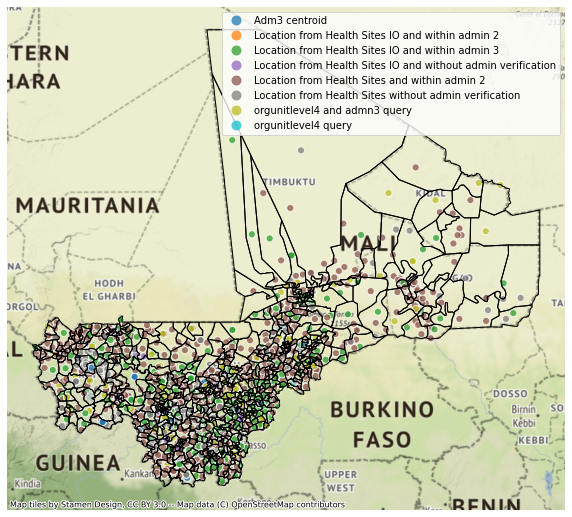

In [789]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
geob3.boundary.plot(ax=ax, color='black', linewidth=1).set_axis_off()
results.loc[results.geocoding_method!="None"].plot(ax=ax, column='geocoding_method', edgecolor='white', markersize=50, alpha=0.75, legend=True)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

## Join attributes from administrative polygons

Join admin data back to results.  
For adm3 features, use spatial join to geob3.  

In [790]:
results2 = results.loc[~(results.longitude.isna())].copy()

In [791]:
# gpd.sjoin?
# depending on geopandas ver, might need to use predicate instead of op

In [792]:
results2 = gpd.sjoin(results2, geob3[["shapeName", "shapeID", "geometry"]], how='left', op='intersects')
results2.drop('index_right', axis=1, inplace=True)

In [793]:
results2.rename(
    columns={
        'shapeName':'geob_adm3',
        'shapeID':'geob_adm3_id',
    }, inplace=True)

In [794]:
results2 = gpd.sjoin(results2, geob2[["shapeName", "shapeID", "geometry"]], how='left', op='intersects')
results2.drop('index_right', axis=1, inplace=True)

In [795]:
results2.geob_adm3.isna().sum(), results2.shapeName.isna().sum()

(1, 1)

In [796]:
results2.rename(
    columns={
        'shapeName':'geob_adm2',
        'shapeID':'geob_adm2_id',
        'adm2':'fuzzy_match_adm2',
        'adm3':'fuzzy_match_adm3'
    }, inplace=True)

In [797]:
#results2.to_file(join(output_dir, "MLI_geocoding_1.27.23.json"), driver='GeoJSON', index=True)

In [798]:
# geob3.to_file(join(output_dir, "MLI_geob3.json"), driver='GeoJSON')

In [799]:
results2

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel4_edit,orgunitlevel3_edit,fuzzy_match_adm3,fuzzy_match_adm2,NAME,geocoding_method,longitude,latitude,geometry,geob_adm3,geob_adm3_id,geob_adm2,geob_adm2_id
1,Mali,Bamako,District Commune I,Asacko Nord,ASACKO NORD,Asacko Nord,Commune I,NaN,NaN,asacko nord,Location from Health Sites without admin verif...,-7.948000,12.663000,POINT (-7.94800 12.66300),Commune I,61693064B6299920369614,Bamako,8926073B64014376877490
3,Mali,Bamako,District Commune I,Asacoba,ASACOBA,Asacoba,Commune I,NaN,NaN,asacoba,Location from Health Sites IO and without admi...,-7.947622,12.591528,POINT (-7.94762 12.59153),Commune VI,61693064B60870670383400,Bamako,8926073B64014376877490
4,Mali,Bamako,District Commune I,Asacoba,Cabinet Medical FONDATION SADIA,Asacoba,Commune I,NaN,NaN,cabinet medical fondation sadia,Location from Health Sites IO and without admi...,-10.725503,15.120675,POINT (-10.72550 15.12068),Toya,61693064B82475235793488,Yelimane,8926073B29693845004508
5,Mali,Bamako,District Commune I,Asacoba,Cabinet Medical TERIYA,Asacoba,Commune I,NaN,NaN,cabinet medical teriya,Location from Health Sites IO and without admi...,-7.962226,12.594632,POINT (-7.96223 12.59463),Commune VI,61693064B60870670383400,Bamako,8926073B64014376877490
6,Mali,Bamako,District Commune I,Asacoboul1,ASACOBOUL1,Asacoboul1,Commune I,NaN,NaN,asacoboul1,Location from Health Sites IO and without admi...,-7.921837,12.675588,POINT (-7.92184 12.67559),Commune I,61693064B6299920369614,Bamako,8926073B64014376877490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,Mali,Tombouctou,District Tombouctou,SankorÃ©,Sankore,SankorÃ©,Tombouctou,NaN,Tombouctou,sankore,Location from Health Sites and within admin 2,-2.767200,17.394600,POINT (-2.76720 17.39460),Salam,61693064B6093748878548,Tombouctou,8926073B71174488748519
1886,Mali,Tombouctou,District Tombouctou,TeherdjÃ©,Teherdje,TeherdjÃ©,Tombouctou,NaN,Tombouctou,teherdje,Location from Health Sites and within admin 2,-1.674200,17.701900,POINT (-1.67420 17.70190),Ber,61693064B26944913284417,Tombouctou,8926073B71174488748519
1887,Mali,Tombouctou,District Tombouctou,Tin Telout,Tin Telout,Tin Telout,Tombouctou,NaN,Tombouctou,tin telout,Location from Health Sites and within admin 2,-3.864000,19.205900,POINT (-3.86400 19.20590),Salam,61693064B6093748878548,Tombouctou,8926073B71174488748519
1889,Mali,Tombouctou,District Tombouctou,Toya,Toya,Toya,Tombouctou,Toya,Tombouctou,toya,Location from Health Sites and within admin 2,-2.777400,16.906900,POINT (-2.77740 16.90690),Bourem Inaly,61693064B60760364335640,Tombouctou,8926073B71174488748519


In [802]:
# FYI saving the results2, the results that were able to be geocoded
print(len(results))
print(len(results2))

1891
1524


In [801]:
results2.to_csv(join(output_dir, "MLI_geocoding_1.27.23.csv"))